<a href="https://colab.research.google.com/github/sumadvena/SiOC_2023/blob/main/SiOC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import interpolate
from sklearn import metrics

from typing import NamedTuple, Sequence

In [14]:
sns.set()

In [15]:
N_MEASUREMENTS = 40

In [16]:
def simple(x):
    return np.sin(x)

def inverted_sin(x):
    return np.sin(np.power(x, -1))

def sign(x):
    return np.sign(np.sin(8*x))

In [17]:
x = np.linspace(-np.pi, np.pi, N_MEASUREMENTS)

y_simple = simple(x)
y_sin_func = inverted_sin(x)
y_sgn_func = sign(x)


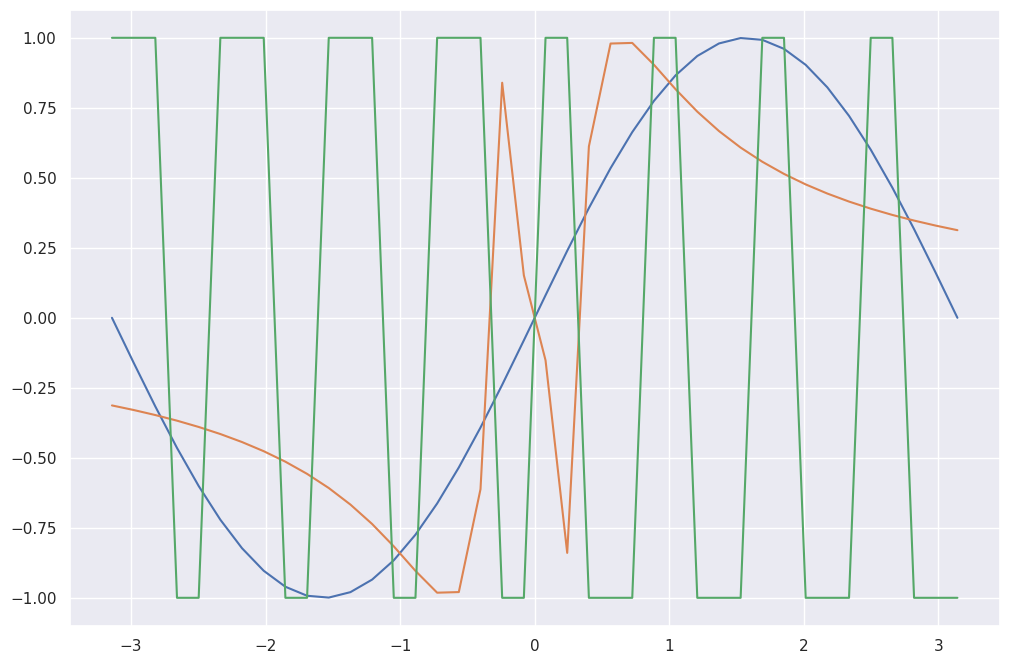

In [18]:
_ = plt.figure(figsize=[12, 8])

_ = plt.plot(x, y_simple)
_ = plt.plot(x, y_sin_func)
_ = plt.plot(x, y_sgn_func)

In [27]:
def nearest_neighbour_kernel(x, offset: float, width: float):
    """Nearest neighbour interpolation kernel"""
    x = x - offset
    return (x >= (-1 * width / 2)) * (x < width / 2)


def linear_kernel(x, offset: float, width: float):
    """Linear interpolation kernel"""
    x = x - offset
    x = x / width
    return (1 - np.abs(x)) * (np.abs(x) < 1)


def sinc_kernel(x, offset: float, width: float, alpha: float = np.pi):
    """Normalized sine interpolation kernel"""
    x = x - offset
    x = x / width
    return (x >= -alpha) * (x < alpha) * np.sinc(x)

In [28]:
class PlotData(NamedTuple):
    """Simple container for plot data"""

    x: Sequence[float]
    y: Sequence[float]


def plot_interpolation(measure: PlotData, interpolation: PlotData, real: PlotData, figsize=(12, 8)):
    """Plot the interpolation, measurements and the real function"""
    figure = plt.figure(figsize=figsize)  # noqa

    plt.scatter(measure.x, measure.y, label="Measurements")
    plt.plot(interpolation.x, interpolation.y, label="Interpolation")
    plt.plot(real.x, real.y, label="Real Function")

    plt.legend()

In [29]:
x_plot = np.linspace(-3, 3, 100)

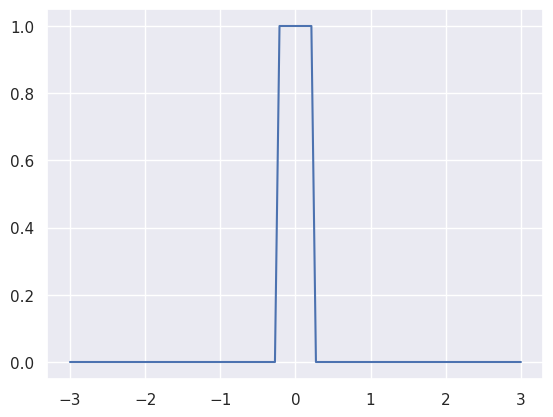

In [34]:
plt.plot(x_plot, nearest_neighbour_kernel(x_plot, offset=0, width=0.5))

In [31]:
def conv1d_interpolate(x_measure: np.array, y_measure: np.array, x_interpolate: np.array, kernel: callable) -> np.array:
    """
    Interpolate using a convolution kernel

    :param x_measure: x values of the measurements
    :param y_measure: y values of the measurements
    :param x_interpolate: x values of the interpolation
    :param kernel: callable interpolation kernel accepting x, offset and width

    :return: y values of the interpolation
    """
    width = x_measure[1] - x_measure[0]  # store period between samples
    kernels = [kernel(x_interpolate, offset=offset, width=width) for offset in x_measure]

    return y_measure @ kernels

MSE: 0.32000000


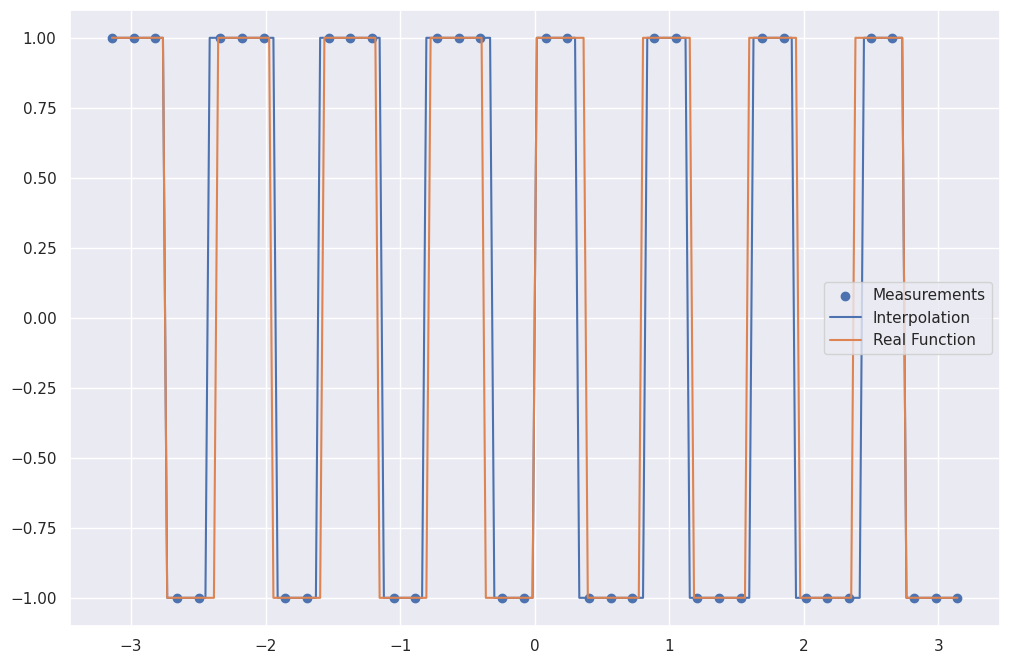

In [76]:
n_predictions = 200

x_interp = np.linspace(-np.pi, np.pi, n_predictions)
y = sign(x)

y_interp = conv1d_interpolate(x_measure=x, y_measure=y, x_interpolate=x_interp, kernel=nearest_neighbour_kernel)
y_true = sign(x_interp)


print(f"MSE: {metrics.mean_squared_error(y_pred=y_interp, y_true=y_true):.8f}")
plot_interpolation(measure=PlotData(x=x, y=y), interpolation=PlotData(x=x_interp, y=y_interp), real=PlotData(x=x_interp, y=y_true))